In [1]:
# test HD-map for gt creation

from nuscenes.nuscenes import NuScenes

dataroot='/home/gs/Datasets/nuScenes/mini'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.281 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.


In [3]:
# 由sample_data_token 得到原图像

import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
img_path = "/home/gs/Datasets/nuScenes/mini/"
sample_data_token = "aa22c2423a5040028b4b31de7bc4ccaf"
sample_data = nusc.get("sample_data", sample_data_token)
orig_img_path = img_path + sample_data['filename']

img = mpimg.imread(orig_img_path)
img = img.reshape(450, 800, 3)
print("img size: ", img.shape)
plt.imshow(img)
plt.axis('off')
sample_data['filename']

ValueError: cannot reshape array of size 4320000 into shape (450,800,3)

In [ ]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
sensor= "CAM_FRONT"
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
# ego_pose_token = cam_front_data['ego_pose_token']
# calibrated_sensor_token = cam_front_data['calibrated_sensor_token']
# ego_pose = nusc.get('ego_pose', ego_pose_token)
# calibrated_sensor = nusc.get('calibrated_sensor', calibrated_sensor_token)

tfm = get_sensor_transform(nusc, cam_front_data)[[0, 1, 3]][:, [0, 2, 3]]
print(tfm)

In [ ]:
nuscenes.get_boxes(cam_front_data['token'])

In [ ]:
from shapely import geometry, affinity

def transform_polygon(polygon, affine):
    """
    Transform a 2D polygon
    """
    a, b, tx, c, d, ty = affine.flatten()[:6]
    print(affine.flatten()[:6])
    return affinity.affine_transform(polygon, [a, b, c, d, tx, ty])

extents = [-25., 1., 25., 50.]
map_patch = geometry.box(*extents)
print(map_patch)
map_patch = transform_polygon(map_patch, tfm)
print(map_patch)

In [ ]:
x1, z1, x2, z2 = extents
print('x1, z1, x2, z2 : ', x1, z1, x2, z2)
resolution = 0.25
mask = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                dtype=np.uint8)
print(mask.shape)

In [ ]:
# load map from nuscenes
import matplotlib.pyplot as plt
import tqdm
import numpy as np

from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.map_expansion import arcline_path_utils
from nuscenes.map_expansion.bitmap import BitMap

nusc_map = NuScenesMap(dataroot='/home/gs/Datasets/nuScenes/mini/', map_name='singapore-onenorth')
log = nuscenes.get('log', my_scene['log_token'])
scene_map_data = map_data[log['location']]
print(scene_map_data)
log

In [ ]:
for layer, polys in scene_map_data.items():
    print(layer)
    print(polys)

In [ ]:
# test mask
def get_visible_mask(instrinsics, image_width, extents, resolution):

    # Get calibration parameters
    fu, cu = instrinsics[0, 0], instrinsics[0, 2]
    print("fu,cu", fu, cu)

    # Construct a grid of image coordinates
    x1, z1, x2, z2 = extents
    x, z = np.arange(x1, x2, resolution), np.arange(z1, z2, resolution)
    ucoords = x / z[:, None] * fu + cu
    print("x:{}, \nz:{} ".format(x, z))
    print("z[:, None]: ", z[:, None].shape)
    print("ucoords.shape: ", x / z[:, None])

    # Return all points which lie within the camera bounds
    return (ucoords >= 0) & (ucoords < image_width)

instrinsics = sensor = nuscenes.get('calibrated_sensor', 
                         cam_front_data['calibrated_sensor_token'])
intrinsics = np.array(sensor['camera_intrinsic'])
image_width = cam_front_data['width']
extents = [-25., 1., 25., 50.]
resolution = 0.25
mask = ~get_visible_mask(intrinsics, image_width, 
                        extents, resolution)
print(mask)
pil_image=Image.fromarray(mask)
pil_image.show()

In [ ]:
a = np.array([-3,-2,-1,0,1,2,3])
b = np.array([1,2,3,4,5,6,7,8,9,10])
mask = a / b[:, None]
print(mask.shape)
mask = mask[:,:,None].transpose(2,0,1)
mask_1 = mask+1
mask = np.concatenate([mask,mask_1], axis=0)
print(mask.shape)
print(mask)
mask[-1]

In [ ]:
# 生成nuScenes数据集的gt
# 参考mono_semantic_maps中的make_nuscenes_labels.py

import os
import sys
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict

from shapely.strtree import STRtree
from nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

sys.path.append(os.path.abspath(os.path.join('', '../..')))

from src.utils.configs import get_default_configuration
from src.data.utils import get_visible_mask, get_occlusion_mask, transform, \
    encode_binary_labels
#import src.data.nuscenes.utils as nusc_utils

In [ ]:
import os
import numpy as np
from shapely import geometry, affinity
from pyquaternion import Quaternion

from nuscenes.eval.detection.utils import category_to_detection_name
from nuscenes.eval.detection.constants import DETECTION_NAMES
from nuscenes.utils.data_classes import LidarPointCloud

#from ..utils import transform_polygon, render_polygon, transform
from src.data.utils import transform_polygon, render_polygon, transform

CAMERA_NAMES = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                'CAM_BACK_LEFT', 'CAM_BACK_RIGHT', 'CAM_BACK']

NUSCENES_CLASS_NAMES = [
    'drivable_area', 'ped_crossing', 'walkway', 'carpark', 'car', 'truck', 
    'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 
    'bicycle', 'traffic_cone', 'barrier'
]

STATIC_CLASSES = ['drivable_area', 'ped_crossing', 'walkway', 'carpark_area']

LOCATIONS = ['boston-seaport', 'singapore-onenorth', 'singapore-queenstown',
             'singapore-hollandvillage']


def iterate_samples(nuscenes, start_token):
    sample_token = start_token
    while sample_token != '':
        sample = nuscenes.get('sample', sample_token)
        yield sample
        sample_token = sample['next']
    

def get_map_masks(nuscenes, map_data, sample_data, extents, resolution):

    # Render each layer sequentially
    layers = [get_layer_mask(nuscenes, polys, sample_data, extents, 
              resolution) for layer, polys in map_data.items()]
    #print("in get_map_masks, layers: ", layers[0].shape)
    #print("in get_map_masks, return np.stack(layers, axis=0): ", np.stack(layers, axis=0).shape)
    return np.stack(layers, axis=0)


def get_layer_mask(nuscenes, polygons, sample_data, extents, resolution):

    # Get the 2D affine transform from bev coords to map coords
    tfm = get_sensor_transform(nuscenes, sample_data)[[0, 1, 3]][:, [0, 2, 3]]
    inv_tfm = np.linalg.inv(tfm)

    # Create a patch representing the birds-eye-view region in map coordinates
    map_patch = geometry.box(*extents)
    map_patch = transform_polygon(map_patch, tfm)

    # Initialise the map mask
    x1, z1, x2, z2 = extents
    mask = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                    dtype=np.uint8)

    # Find all polygons which intersect with the area of interest
    for polygon in polygons.query(map_patch):

        polygon = polygon.intersection(map_patch)
        
        # Transform into map coordinates
        polygon = transform_polygon(polygon, inv_tfm)

        # Render the polygon to the mask
        render_shapely_polygon(mask, polygon, extents, resolution)
    
    return mask.astype(np.bool)




def get_object_masks(nuscenes, sample_data, extents, resolution):

    # Initialize object masks
    nclass = len(DETECTION_NAMES) + 1
    grid_width = int((extents[2] - extents[0]) / resolution)
    grid_height = int((extents[3] - extents[1]) / resolution)
    masks = np.zeros((nclass, grid_height, grid_width), dtype=np.uint8)

    # Get the 2D affine transform from bev coords to map coords
    tfm = get_sensor_transform(nuscenes, sample_data)[[0, 1, 3]][:, [0, 2, 3]]
    inv_tfm = np.linalg.inv(tfm)

    for box in nuscenes.get_boxes(sample_data['token']):

        # Get the index of the class
        det_name = category_to_detection_name(box.name)
        if det_name not in DETECTION_NAMES:
            class_id = -1
        else:
            class_id = DETECTION_NAMES.index(det_name)
        
        # Get bounding box coordinates in the grid coordinate frame
        bbox = box.bottom_corners()[:2]
        local_bbox = np.dot(inv_tfm[:2, :2], bbox).T + inv_tfm[:2, 2]

        # Render the rotated bounding box to the mask
        render_polygon(masks[class_id], local_bbox, extents, resolution)
    
    #print('in get_object_masks, return masks.astype(np.bool): ', masks.astype(np.bool).shape)
    return masks.astype(np.bool)


def get_sensor_transform(nuscenes, sample_data):

    # Load sensor transform data
    sensor = nuscenes.get(
        'calibrated_sensor', sample_data['calibrated_sensor_token'])
    sensor_tfm = make_transform_matrix(sensor)

    # Load ego pose data
    pose = nuscenes.get('ego_pose', sample_data['ego_pose_token'])
    pose_tfm = make_transform_matrix(pose)

    return np.dot(pose_tfm, sensor_tfm)


def load_point_cloud(nuscenes, sample_data):

    # Load point cloud
    lidar_path = os.path.join(nuscenes.dataroot, sample_data['filename'])
    pcl = LidarPointCloud.from_file(lidar_path)
    return pcl.points[:3, :].T


def make_transform_matrix(record):
    """
    Create a 4x4 transform matrix from a calibrated_sensor or ego_pose record
    """
    transform = np.eye(4)
    transform[:3, :3] = Quaternion(record['rotation']).rotation_matrix
    transform[:3, 3] = np.array(record['translation'])
    return transform


def render_shapely_polygon(mask, polygon, extents, resolution):

    if polygon.geom_type == 'Polygon':

        # Render exteriors
        render_polygon(mask, polygon.exterior.coords, extents, resolution, 1)

        # Render interiors
        for hole in polygon.interiors:
            render_polygon(mask, hole.coords, extents, resolution, 0)
    
    # Handle the case of compound shapes
    else:
        #for poly in polygon:
        for poly in polygon.geoms:
            render_shapely_polygon(mask, poly, extents, resolution)


In [ ]:
global masks_check
global labels_check
global gt_check = []

In [ ]:
def process_scene(nuscenes, map_data, scene, config):

    # Get the map corresponding to the current sample data
    log = nuscenes.get('log', scene['log_token'])
    scene_map_data = map_data[log['location']]

    # Iterate over samples
    # modified by GS, exclude the first_sample_token
    first_sample_token = scene['first_sample_token']
    first_sample = nuscenes.get('sample', first_sample_token)
    start_token = first_sample['next']
    for sample in iterate_samples(nuscenes, start_token):
        process_sample(nuscenes, scene_map_data, sample, config)
        


def process_sample(nuscenes, map_data, sample, config):

    # Load the lidar point cloud associated with this sample
    lidar_data = nuscenes.get('sample_data', sample['data']['LIDAR_TOP'])
    lidar_pcl = load_point_cloud(nuscenes, lidar_data)

    # Transform points into world coordinate system
    lidar_transform = get_sensor_transform(nuscenes, lidar_data)
    lidar_pcl = transform(lidar_transform, lidar_pcl)

    # Iterate over sample data
    for camera in CAMERA_NAMES:
        sample_data = nuscenes.get('sample_data', sample['data'][camera])
        process_sample_data(nuscenes, map_data, sample_data, lidar_pcl, config)


def process_sample_data(nuscenes, map_data, sample_data, lidar, config):
    global masks_check
    global labels_check
    global gt_check

    # Render static road geometry masks
    map_masks = get_map_masks(nuscenes, 
                                         map_data, 
                                         sample_data, 
                                         config.map_extents, 
                                         config.map_resolution)
    
    # Render dynamic object masks
    obj_masks = get_object_masks(nuscenes, 
                                            sample_data, 
                                            config.map_extents, 
                                            config.map_resolution)
    masks = np.concatenate([map_masks, obj_masks], axis=0)

    # Ignore regions of the BEV which are outside the image
    sensor = nuscenes.get('calibrated_sensor', 
                         sample_data['calibrated_sensor_token'])
    intrinsics = np.array(sensor['camera_intrinsic'])
    #masks[-1] |= ~get_visible_mask(intrinsics, sample_data['width'], 
    #                              config.map_extents, config.map_resolution)
   
    # Transform lidar points into camera coordinates
    cam_transform = get_sensor_transform(nuscenes, sample_data)
    cam_points = transform(np.linalg.inv(cam_transform), lidar)
    masks[-1] |= get_occlusion_mask(cam_points, config.map_extents,
                                   config.map_resolution)
    
    # Encode masks as integer bitmask
    masks_check = masks  # (15, 196, 200) bool
    gt_chech.append(masks)
    labels = encode_binary_labels(masks)
    labels_check = labels

    # Save outputs to disk
    output_path = os.path.join(os.path.expandvars(config.label_root),sample_data['token'] + '.png')
    Image.fromarray(labels.astype(np.int32), mode='I').save(output_path)


def load_map_data(dataroot, location):

    # Load the NuScenes map object
    nusc_map = NuScenesMap(dataroot, location)

    map_data = OrderedDict()
    for layer in STATIC_CLASSES:
        
        # Retrieve all data associated with the current layer
        records = getattr(nusc_map, layer)
        polygons = list()

        # Drivable area records can contain multiple polygons
        if layer == 'drivable_area':
            for record in records:

                # Convert each entry in the record into a shapely object
                for token in record['polygon_tokens']:
                    poly = nusc_map.extract_polygon(token)
                    if poly.is_valid:
                        polygons.append(poly)
        else:
            for record in records:

                # Convert each entry in the record into a shapely object
                poly = nusc_map.extract_polygon(record['polygon_token'])
                if poly.is_valid:
                    polygons.append(poly)

        
        # Store as an R-Tree for fast intersection queries
        map_data[layer] = STRtree(polygons)
    
    return map_data

In [ ]:
if __name__ == '__main__':

    # Load the default configuration
    config = get_default_configuration()
    config.merge_from_file('configs/datasets/nuscenes.yml')

    # Load NuScenes dataset
    dataroot = os.path.expandvars(config.dataroot)
    nuscenes = NuScenes(config.nuscenes_version, dataroot)

    # Preload NuScenes map data
    map_data = { location : load_map_data(dataroot, location) 
                 for location in LOCATIONS }
    
    # Create a directory for the generated labels
    output_root = os.path.expandvars(config.label_root)
    os.makedirs(output_root, exist_ok=True)
    
   # print(nuscenes.scene)
    # Iterate over NuScene scenes
    i = 0
    print("\nGenerating labels...")
    for scene in tqdm(nuscenes.scene):
        print("we are in main function, lets see scene{}: {}".format(i, scene))
        process_scene(nuscenes, map_data, scene, config)
        i += 1
        #break


In [ ]:
masks_check  #(15, 196, 200) bool
labels_check  #(196, 200)  encode以后的标签，数值在16384 16384左右
print(masks_check.shape, "\n", masks_check)

#print(labels_check.shape, "\n", labels_check)

In [ ]:
from semantic_map.combinators import Rasterizer

one_hot = np.array(masks_check.transpose(1,2,0)).astype(int)  #(196, 200, 15)   0,1值
label = labels_check
#print(mask.shape, "\n", mask)

nbr_class = one_hot.shape[2]
images = []
map_mask = np.zeros(one_hot.shape, dtype=np.int32)
for i in range(nbr_class):
    map_mask[:,:,i] = np.where(one_hot[:,:,i]==1, i+1, 0)
    image = np.repeat(np.expand_dims(map_mask[:,:,i], axis=2), 3, axis=2).astype(np.uint8)
    images.append(image)

combinator = Rasterizer()
img_combinator = combinator.combine(data=images)
GT = img_combinator[:,:,0]
print(GT.shape)
print(np.max(GT))

In [ ]:
# visualize the masks

print(masks_check.shape)
def create_visual_anno(anno):
    assert np.max(anno) <= 15, "only 13 classes are supported, add new color in label2color_dict"
    # label2color_dict = {
    #     0: [0, 0, 0],
    #     1: [255, 248, 220],  # cornsilk
    #     2: [100, 149, 237],  # cornflowerblue
    #     3: [102, 205, 170],  # mediumAquamarine
    #     4: [205, 133, 63],  # peru
    #     5: [160, 32, 240],  # purple
    #     6: [255, 64, 64],  # brown1
    #     7: [139, 69, 19],  # Chocolate4
    #     8: [255, 127, 0],  # DarkOrange1
    #     9: [34, 139, 34]   # ForestGreen
    # }
    labels = {
        0: "drivable_area",
        1: "ped_crossing",
        2: "walkway",
        3: "carpark",
        4: "car",  #traffic corn
        5: "truck",
        6: "bus",
        7: "trailer",
        8: "construction_vehicle",
        9: "pedestrian",
        10:"motorcycle",
        11:"bicycle",
        12:"traffic_cone",
        13:"barrier",
        14:"unlabel"
    }
    # label2color_dict = {
    #     0: [255, 248, 220],
    #     1: [31, 203, 255],  # blue
    #     2: [251, 31, 255],  # cimare
    #     3: [31, 34, 255],  # deep blue
    #     4: [255, 251, 31],  # red 
    #     5: [31, 255, 139],  # purple
    #     6: [245, 123, 102],  # orange
    #     7: [120, 255, 50], #green  

    #     8: [255, 0, 0],   
    #     9: [100, 149, 237]
    # }
    label2color_dict = {
        #0: [255, 248, 220],
        0: [0, 0, 0],  #empty eare
        1: [255, 0, 255], # driveable_area  cimare
        2: [150, 240, 80], # ped_crossing green
        3: [100, 80, 250], # walkway  blue
        4: [135, 60, 0], # carpark brown  
        5: [255, 200, 0], # car  yellow
        6: [148, 41, 255], # truck purple
        #7: [245, 123, 102] #static_object orange
        7: [255, 0, 0],  # bus
        8: [100, 149, 237],  # trailer
        9: [102, 205, 170],  # construction_vehicle
        10:[205, 133, 63],  # pedestrian
        11:[160, 32, 240],  # motorcycle
        12:[139, 69, 19],  # bicycle
        13:[100, 149, 237],  # traffic_cone
        14:[255, 127, 0],  # barrier
        15:[0, 0, 0]  # mask
    }

    #visual
    visual_anno = np.zeros((anno.shape[0], anno.shape[1], 3), dtype=np.uint8)
    for i in range(visual_anno.shape[0]):
        for j in range(visual_anno.shape[1]):
            color = label2color_dict[anno[i, j]]
            visual_anno[i, j, 0] = color[0]
            visual_anno[i, j, 1] = color[1]
            visual_anno[i, j, 2] = color[2]
    return visual_anno


visual_anno = create_visual_anno(GT)
pil_image=Image.fromarray(visual_anno)
pil_image.show()

In [ ]:
from functools import reduce
from typing import List

import cv2
import numpy as np

from prediction.input_representation.interface import Combinator


def add_foreground_to_image(base_image: np.ndarray,
                            foreground_image: np.ndarray) -> np.ndarray:
    """
    Overlays a foreground image on top of a base image without mixing colors. Type uint8.
    :param base_image: Image that will be the background. Type uint8.
    :param foreground_image: Image that will be the foreground.
    :return: Image Numpy array of type uint8.
    """

    if not base_image.shape == foreground_image.shape:
        raise ValueError("base_image and foreground image must have the same shape."
                         " Received {} and {}".format(base_image.shape, foreground_image.shape))

    if not (base_image.dtype == "uint8" and foreground_image.dtype == "uint8"):
        raise ValueError("base_image and foreground image must be of type 'uint8'."
                         " Received {} and {}".format(base_image.dtype, foreground_image.dtype))

    #print("we are in combinators.py, base_image###", np.max(base_image))
    img2gray = cv2.cvtColor(foreground_image, cv2.COLOR_BGR2GRAY)
    print("we are in combinators.py, max in img2gray",np.max(img2gray))
    _, mask = cv2.threshold(img2gray, 0, 255, cv2.THRESH_BINARY)
    print("we are in combinators.py, max in mask",np.max(mask))
    mask_inv = cv2.bitwise_not(mask)
    img1_bg = cv2.bitwise_and(base_image, base_image, mask=mask_inv)
    img2_fg = cv2.bitwise_and(foreground_image, foreground_image, mask=mask)
    combined_image = cv2.add(img1_bg, img2_fg)
    return combined_image


class Rasterizer(Combinator):
    """
    Combines images into a three channel image.
    """

    def combine(self, data: List[np.ndarray]) -> np.ndarray:
        """
        Combine three channel images into a single image.
        :param data: List of images to combine.
        :return: Numpy array representing image (type 'uint8')
        """
        # All images in the dict are the same shape
        image_shape = data[0].shape
        #print("we are in combinators.py, data.shape", data[1].shape)

        base_image = np.zeros(image_shape).astype("uint8")
        return reduce(add_foreground_to_image, [base_image] + data)

combinator = Rasterizer()
img_combinator = combinator.combine(data=images)
GT = img_combinator[:,:,0]
print(len(images))

In [ ]:
import cv2
import numpy as np
img = cv2.imread("/home/gs/workspace/0_code/grid_map/cross_view_grid_map1/data-local/Cityscapes/Cityscapes_frankfurt_GT/frankfurt_000000_000294_occ_map_manual.png")
print(img.shape)
img1 = img[:,:,0]
img2 = img[:,:,1]
img3 = img[:,:,2]
if img1.all() == img2.all():
    if img1.all() == img3.all():
        print("all equal")
else:
    print("not equal")

In [18]:
#分层查看gt
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap
from collections import OrderedDict
import src.data.nuscenes.utils as nusc_utils
from shapely.strtree import STRtree
from src.utils.configs import get_default_configuration
from src.data.utils import get_visible_mask, get_occlusion_mask, transform, \
    encode_binary_labels
import numpy as np


def load_map_data(dataroot, location):

    # Load the NuScenes map object
    nusc_map = NuScenesMap(dataroot, location)

    map_data = OrderedDict()
    for layer in nusc_utils.STATIC_CLASSES:
        
        # Retrieve all data associated with the current layer
        records = getattr(nusc_map, layer)
        polygons = list()

        # Drivable area records can contain multiple polygons
        if layer == 'drivable_area':
            for record in records:

                # Convert each entry in the record into a shapely object
                for token in record['polygon_tokens']:
                    poly = nusc_map.extract_polygon(token)
                    if poly.is_valid:
                        polygons.append(poly)
        else:
            for record in records:

                # Convert each entry in the record into a shapely object
                poly = nusc_map.extract_polygon(record['polygon_token'])
                if poly.is_valid:
                    polygons.append(poly)

        
        # Store as an R-Tree for fast intersection queries
        map_data[layer] = STRtree(polygons)
    
    return map_data

# nuscenes-mini
#dataroot='/home/gs/Datasets/nuScenes/mini'
#nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

# nuscenes-trainval
dataroot = '/home/gs/workspace/datasets/nuScenes/trainval'
nusc = NuScenes(version='v1.0-trainval', dataroot=dataroot, verbose=True)

LOCATIONS = ['boston-seaport', 'singapore-onenorth', 'singapore-queenstown',
             'singapore-hollandvillage']
map_data = { location : load_map_data(dataroot, location) 
             for location in LOCATIONS }

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.187 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


samples/CAM_FRONT/n015-2018-10-08-15-36-50+0800__CAM_FRONT__1538984235412460.jpg
(900, 1600, 3)


{'token': '325cef682f064c55a255f2625c533b75',
 'log_token': '5bd40b613ac740cd9dbacdfbc3d68201',
 'nbr_samples': 41,
 'first_sample_token': 'b5989651183643369174912bc5641d3b',
 'last_sample_token': 'b4ff30109dd14c89b24789dc5713cf8c',
 'name': 'scene-0916',
 'description': 'Parking lot, bicycle rack, parked bicycles, bus, many peds, parked scooters, parked motorcycle'}

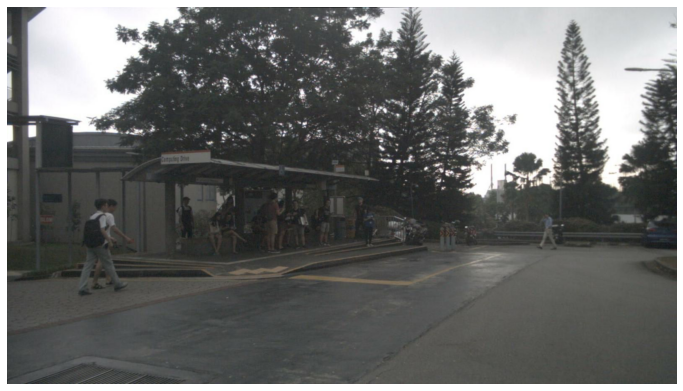

In [19]:
#分层查看gt
#找到原图
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片

def get_scene(token):
    sample_data = nusc.get('sample_data', token)
    sample_token = sample_data['sample_token']
    sample = nusc.get('sample', sample_token)
    scene_token = sample['scene_token']
    scene = nusc.get('scene', scene_token)
    scene_token = scene['token']
    return sample, scene

#img_path = "/home/gs/Datasets/nuScenes/mini/"
img_path = '/home/gs/workspace/datasets/nuScenes/trainval/'
sample_data_token = "b08a2deaf871433fad9a4c03e6f53d32"
sample_data = nusc.get("sample_data", sample_data_token)
orig_img_path = img_path + sample_data['filename']
sensor = sample_data['filename'].split("/")[1]

sample, scene = get_scene(sample_data_token)
scene_name = scene['name']

img = mpimg.imread(orig_img_path)
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.imshow(img)
plt.axis('off')
print(sample_data['filename'])
print(img.shape)

ego_pose = nusc.get("ego_pose", sample_data['ego_pose_token'])
scene

/home/gs/miniconda3/envs/dataset/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/gs/miniconda3/envs/dataset/lib/python3.8/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


(1972.0836340962353, 754.0903291396098, 50, 50)

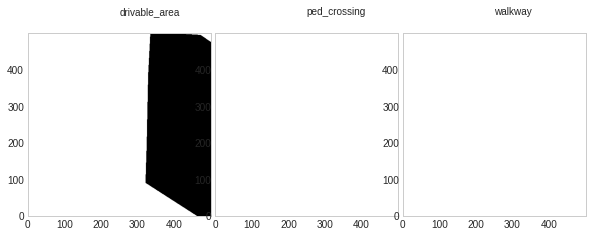

In [13]:
#分层查看gt
# 从map直接看drivable_area
from pyquaternion import Quaternion

def quaternion_yaw(q: Quaternion) -> float:
    """
    Calculate the yaw angle from a quaternion.
    Note that this only works for a quaternion that represents a box in lidar or global coordinate frame.
    It does not work for a box in the camera frame.
    :param q: Quaternion of interest.
    :return: Yaw angle in radians.
    """

    # Project into xy plane.
    v = np.dot(q.rotation_matrix, np.array([1, 0, 0]))

    # Measure yaw using arctan.
    yaw = np.arctan2(v[1], v[0])

    return yaw

def correct_yaw(yaw: float) -> float:
    """
    nuScenes maps were flipped over the y-axis, so we need to
    add pi to the angle needed to rotate the heading.
    :param yaw: Yaw angle to rotate the image.
    :return: Yaw after correction.
    """
    if yaw <= 0:
        yaw = -np.pi - yaw
    else:
        yaw = np.pi - yaw

    return yaw

def angle_of_rotation(yaw: float) -> float:
    """
    Given a yaw angle (measured from x axis), find the angle needed to rotate by so that
    the yaw is aligned with the y axis (pi / 2).
    :param yaw: Radians. Output of quaternion_yaw function.
    :return: Angle in radians.
    """
    return (np.pi / 2) + np.sign(-yaw) * np.abs(yaw)


layer_names = ['drivable_area', 'ped_crossing', 'walkway']
resolution = 0.25

log = nusc.get('log', scene['log_token'])
nusc_map = NuScenesMap(dataroot, log['location'])

sensor_pose = nusc.get("ego_pose", sample_data['ego_pose_token'])
translation = sensor_pose["translation"]
rotation = sensor_pose["rotation"]
x,y = translation[:2]
yaw = quaternion_yaw(Quaternion(rotation))
yaw_corrected = correct_yaw(yaw)

image_side_length = 2 * max(50, 1, 25, 25)
image_side_length_pixels = int(image_side_length / resolution)

#patchbox = (x, y, image_side_length, image_side_length)
patch_1 = 50
patch_2 = 50
patchbox = (x-10, y-30, patch_1, patch_2)
angle_in_degrees = angle_of_rotation(yaw_corrected) * 180 / np.pi
canvas_size = (image_side_length_pixels, image_side_length_pixels)

#masks = nusc_map.get_map_mask(patchbox, angle_in_degrees, layer_names, canvas_size=canvas_size)
figsize = (10, 4)
fig, ax = nusc_map.render_map_mask(patchbox, angle_in_degrees, layer_names, canvas_size=(patch_1*10,patch_2*10), figsize=figsize, n_row=1)


#sensor_pose
patchbox

In [14]:
#分层查看gt

import os
import numpy as np
from shapely import geometry, affinity
from pyquaternion import Quaternion

from nuscenes.eval.detection.utils import category_to_detection_name
from nuscenes.eval.detection.constants import DETECTION_NAMES
from nuscenes.utils.data_classes import LidarPointCloud

from src.data.utils import transform_polygon, render_polygon, transform

CAMERA_NAMES = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT', 
                'CAM_BACK_LEFT', 'CAM_BACK_RIGHT', 'CAM_BACK']

NUSCENES_CLASS_NAMES = [
    'drivable_area', 'ped_crossing', 'walkway', 'carpark', 'car', 'truck', 
    'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 
    'bicycle', 'traffic_cone', 'barrier'
]

STATIC_CLASSES = ['drivable_area', 'ped_crossing', 'walkway', 'carpark_area']

LOCATIONS = ['boston-seaport', 'singapore-onenorth', 'singapore-queenstown',
             'singapore-hollandvillage']


global drivable_mask

def iterate_samples(nuscenes, start_token):
    sample_token = start_token
    while sample_token != '':
        sample = nuscenes.get('sample', sample_token)
        yield sample
        sample_token = sample['next']
    

def get_map_masks(nuscenes, map_data, sample_data, extents, resolution):

    global drivable_mask
    # Render each layer sequentially
    #layers = [get_layer_mask(nuscenes, polys, sample_data, extents, 
    #          resolution) for layer, polys in map_data.items()]
    
    layers = []
    for layer, polys in map_data.items():
        mask = get_layer_mask(nuscenes, polys, sample_data, extents, 
              resolution)
        layers.append(mask)
        if layer == 'drivable_area':
            drivable_mask = mask
        print("in get_map_masks, layer is: ", layer)
        print("in get_map_masks, polys is: ", polys)
    print("in get_map_masks, layers.shape: ", len(layers))

    return np.stack(layers, axis=0)


def get_layer_mask(nuscenes, polygons, sample_data, extents, resolution):

    # Get the 2D affine transform from bev coords to map coords
    tfm = get_sensor_transform(nuscenes, sample_data)[[0, 1, 3]][:, [0, 2, 3]]
    inv_tfm = np.linalg.inv(tfm)

    # Create a patch representing the birds-eye-view region in map coordinates
    map_patch = geometry.box(*extents)
    map_patch = transform_polygon(map_patch, tfm)

    # Initialise the map mask
    x1, z1, x2, z2 = extents
    mask = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                    dtype=np.uint8)

    # Find all polygons which intersect with the area of interest
    for polygon in polygons.query(map_patch):

        polygon = polygon.intersection(map_patch)
        
        # Transform into map coordinates
        polygon = transform_polygon(polygon, inv_tfm)

        # Render the polygon to the mask
        render_shapely_polygon(mask, polygon, extents, resolution)
        print("in get_layer_mask, mask for return is: ", mask.shape)
    
    return mask.astype(bool)




def get_object_masks(nuscenes, sample_data, extents, resolution):

    # Initialize object masks
    nclass = len(DETECTION_NAMES) + 1
    grid_width = int((extents[2] - extents[0]) / resolution)
    grid_height = int((extents[3] - extents[1]) / resolution)
    masks = np.zeros((nclass, grid_height, grid_width), dtype=np.uint8)

    # Get the 2D affine transform from bev coords to map coords
    tfm = get_sensor_transform(nuscenes, sample_data)[[0, 1, 3]][:, [0, 2, 3]]
    inv_tfm = np.linalg.inv(tfm)

    for box in nuscenes.get_boxes(sample_data['token']):

        # Get the index of the class
        det_name = category_to_detection_name(box.name)
        if det_name not in DETECTION_NAMES:
            class_id = -1
        else:
            class_id = DETECTION_NAMES.index(det_name)
        
        # Get bounding box coordinates in the grid coordinate frame
        bbox = box.bottom_corners()[:2]
        local_bbox = np.dot(inv_tfm[:2, :2], bbox).T + inv_tfm[:2, 2]

        # Render the rotated bounding box to the mask
        render_polygon(masks[class_id], local_bbox, extents, resolution)
    
    return masks.astype(np.bool)


def get_sensor_transform(nuscenes, sample_data):

    # Load sensor transform data
    sensor = nuscenes.get(
        'calibrated_sensor', sample_data['calibrated_sensor_token'])
    sensor_tfm = make_transform_matrix(sensor)

    # Load ego pose data
    pose = nuscenes.get('ego_pose', sample_data['ego_pose_token'])
    pose_tfm = make_transform_matrix(pose)

    return np.dot(pose_tfm, sensor_tfm)


def load_point_cloud(nuscenes, sample_data):

    # Load point cloud
    lidar_path = os.path.join(nuscenes.dataroot, sample_data['filename'])
    pcl = LidarPointCloud.from_file(lidar_path)
    return pcl.points[:3, :].T


def make_transform_matrix(record):
    """
    Create a 4x4 transform matrix from a calibrated_sensor or ego_pose record
    """
    transform = np.eye(4)
    transform[:3, :3] = Quaternion(record['rotation']).rotation_matrix
    transform[:3, 3] = np.array(record['translation'])
    return transform


def render_shapely_polygon(mask, polygon, extents, resolution):

    if polygon.geom_type == 'Polygon':

        # Render exteriors
        render_polygon(mask, polygon.exterior.coords, extents, resolution, 1)

        # Render interiors
        for hole in polygon.interiors:
            render_polygon(mask, hole.coords, extents, resolution, 0)
    
    # Handle the case of compound shapes
    else:
        #for poly in polygon:
        for poly in polygon.geoms:
            render_shapely_polygon(mask, poly, extents, resolution)



In [15]:
#分层查看gt

def process_sample_data(nuscenes, map_data, sample_data, lidar, config):

    # Render static road geometry masks
    map_masks = get_map_masks(nuscenes, 
                                         map_data, 
                                         sample_data, 
                                         config.map_extents, 
                                         config.map_resolution)
    
    # Render dynamic object masks
    obj_masks = nusc_utils.get_object_masks(nuscenes, 
                                            sample_data, 
                                            config.map_extents, 
                                            config.map_resolution)
    masks = np.concatenate([map_masks, obj_masks], axis=0)  # mask.shape (15, 196, 200)

    # Ignore regions of the BEV which are outside the image
    sensor = nuscenes.get('calibrated_sensor', 
                          sample_data['calibrated_sensor_token'])
    intrinsics = np.array(sensor['camera_intrinsic'])
    #masks[-1] |= ~get_visible_mask(intrinsics, sample_data['width'], 
    #                               config.map_extents, config.map_resolution)
    
    # Transform lidar points into camera coordinates
    cam_transform = nusc_utils.get_sensor_transform(nuscenes, sample_data)
    cam_points = transform(np.linalg.inv(cam_transform), lidar)
    #masks[-1] |= get_occlusion_mask(cam_points, config.map_extents,
    #                                config.map_resolution)
    
    return masks

In [16]:
#分层查看gt
config = get_default_configuration()
config.merge_from_file('configs/datasets/nuscenes.yml')

log = nusc.get('log', scene['log_token'])
scene_map_data = map_data[log['location']]


# Load the lidar point cloud associated with this sample
lidar_data = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
lidar_pcl = nusc_utils.load_point_cloud(nusc, lidar_data)

# Transform points into world coordinate system
lidar_transform = nusc_utils.get_sensor_transform(nusc, lidar_data)
lidar_pcl = transform(lidar_transform, lidar_pcl)

masks_check = process_sample_data(nusc, scene_map_data, sample_data, lidar_pcl, config)

in get_layer_mask, mask for return is:  (196, 200)
in get_layer_mask, mask for return is:  (196, 200)
in get_map_masks, layer is:  drivable_area
in get_map_masks, polys is:  <shapely.strtree.STRtree object at 0x7ff3e3e632e0>
in get_layer_mask, mask for return is:  (196, 200)
in get_layer_mask, mask for return is:  (196, 200)
in get_layer_mask, mask for return is:  (196, 200)
in get_map_masks, layer is:  ped_crossing
in get_map_masks, polys is:  <shapely.strtree.STRtree object at 0x7ff3e3e63280>
in get_layer_mask, mask for return is:  (196, 200)
in get_layer_mask, mask for return is:  (196, 200)
in get_layer_mask, mask for return is:  (196, 200)
in get_map_masks, layer is:  walkway
in get_map_masks, polys is:  <shapely.strtree.STRtree object at 0x7ff3e3e63310>
in get_map_masks, layer is:  carpark_area
in get_map_masks, polys is:  <shapely.strtree.STRtree object at 0x7ff2a97c9fa0>
in get_map_masks, layers.shape:  4


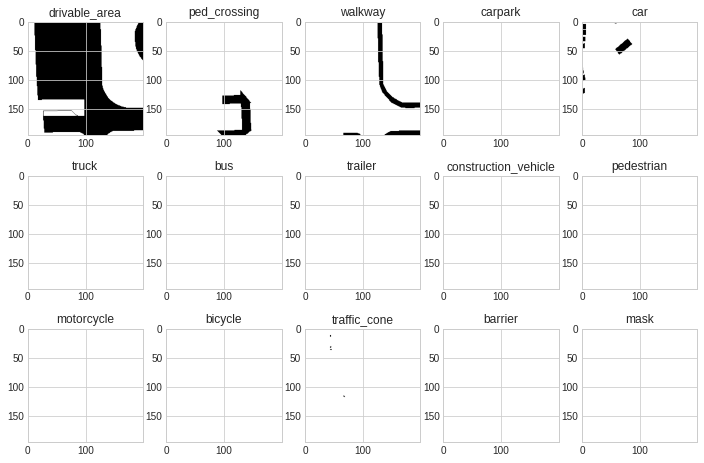

(15, 196, 200)


In [17]:
#分层查看gt

import torch
import numpy as np

from PIL import Image




# masks_check为(15, 196, 200)
NUSCENES_CLASS_NAMES = [
    'drivable_area', 'ped_crossing', 'walkway', 'carpark', 'car', 'truck', 
    'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 
    'bicycle', 'traffic_cone', 'barrier','mask'
]

labels = {}
plt.rcParams['figure.figsize'] = (12.0, 8.0)
for i in range(len(NUSCENES_CLASS_NAMES)):
    labels[NUSCENES_CLASS_NAMES[i]] = masks_check[i]
    plt.subplot(3, 5, i+1)
    plt.imshow(masks_check[i])
    plt.title(NUSCENES_CLASS_NAMES[i])
    
plt.show()
    

print(masks_check.shape)
drive_road = drivable_mask
pil_image=Image.fromarray(drive_road)
pil_image.show()

# drive_road = masks_check[0]
# pil_image=Image.fromarray(drive_road)
# pil_image.show()
# 
# print(labels_check.shape)
# print(labels_check)
# masks_check_trans = masks_check.transpose(1,2,0)
# onehot_mask = np.array(masks_check_trans).astype(int)
# onehot_mask = torch.from_numpy(onehot_mask)
# #print(onehot_mask)
# mask_label = torch.argmax(onehot_mask, -1)
# 
# print(mask_label)
# mask_label = mask_label.numpy()
# print(np.unique(mask_label))
# 
# #print(labels_check)
# 
# def decode_binary_labels(labels, nclass):
#     labels = torch.from_numpy(labels)
#     bits = torch.pow(2, torch.arange(nclass))
#     return (labels & bits.view(-1, 1, 1)) > 0
# 
# label_decoded = decode_binary_labels(labels_check, 14)
# #print(label_decoded)

In [ ]:
# 分层查看gt
# polys in map

from shapely import geometry, affinity
import cv2

def load_map_data(dataroot, location):

    # Load the NuScenes map object
    nusc_map = NuScenesMap(dataroot, location)

    map_data = OrderedDict()
    for layer in nusc_utils.STATIC_CLASSES:
        
        # Retrieve all data associated with the current layer
        records = getattr(nusc_map, layer)
        polygons = list()

        # Drivable area records can contain multiple polygons
        if layer == 'drivable_area':
            for record in records:

                # Convert each entry in the record into a shapely object
                for token in record['polygon_tokens']:
                    poly = nusc_map.extract_polygon(token)
                    if poly.is_valid:
                        polygons.append(poly)
        else:
            for record in records:

                # Convert each entry in the record into a shapely object
                poly = nusc_map.extract_polygon(record['polygon_token'])
                if poly.is_valid:
                    polygons.append(poly)

        
        # Store as an R-Tree for fast intersection queries
        map_data[layer] = STRtree(polygons)
    
    return map_data

# 得到变换矩阵
def get_sensor_transform(nuscenes, sample_data):

    # Load sensor transform data
    sensor = nuscenes.get(
        'calibrated_sensor', sample_data['calibrated_sensor_token'])
    sensor_tfm = make_transform_matrix(sensor)

    # Load ego pose data
    pose = nuscenes.get('ego_pose', sample_data['ego_pose_token'])
    pose_tfm = make_transform_matrix(pose)

    return np.dot(pose_tfm, sensor_tfm)

def transform_polygon(polygon, affine):
    """
    Transform a 2D polygon
    """
    a, b, tx, c, d, ty = affine.flatten()[:6]
    return affinity.affine_transform(polygon, [a, b, c, d, tx, ty])


def render_shapely_polygon(mask, polygon, extents, resolution):
    print("in render_shapely_polygon")
    if polygon.geom_type == 'Polygon':

        # Render exteriors
        render_polygon(mask, polygon.exterior.coords, extents, resolution, 1)
        plt.subplot(1,3,2)
        plt.imshow(mask)
        plt.title("render_shapely_polygon, Render exteriors")

        # Render interiors
        for hole in polygon.interiors:
            render_polygon(mask, hole.coords, extents, resolution, 0)
        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.title("render_shapely_polygon, Render interiors")
    
    # Handle the case of compound shapes
    else:
        #for poly in polygon:
        for poly in polygon.geoms:
            render_shapely_polygon(mask, poly, extents, resolution)


log = nusc.get('log', scene['log_token'])
# map_data's type is OrderedDict for one location.the key is layerName and value is <shapely.strtree.STRtree at 0x7fef504b1ca0>
map_data = load_map_data(dataroot, log['location'])   

tfm = get_sensor_transform(nusc, sample_data)[[0, 1, 3]][:, [0, 2, 3]]
inv_tfm = np.linalg.inv(tfm)
extents = [-25., 1., 25., 50.]
resolution = 0.25
map_patch = geometry.box(*extents)
map_patch = transform_polygon(map_patch, tfm)

x1, z1, x2, z2 = extents
mask = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                dtype=np.uint8)
mask_hole = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                dtype=np.uint8)


polygons = map_data['drivable_area']  # drivable_area ped_crossing walkway carpark_area
polygon_list = []
polygon_ex = []

plt.rcParams['figure.figsize'] = (12.0, 8.0)
for polygon in polygons.query(map_patch):
    polygon = polygon.intersection(map_patch)
    polygon = transform_polygon(polygon, inv_tfm)
    polygon_show = polygon
    polygon_list.append(polygon)
    
    #render_shapely_polygon(mask, polygon, extents, resolution)
    
    polygon_ex = (polygon.exterior.coords - np.array(extents[:2])) / resolution
    #polygon = polygon.exterior.coords
    polygon_ex = np.ascontiguousarray(polygon_ex).round().astype(np.int32)  # 变成像坐标一样的集合
    print(polygon_ex)
    cv2.fillConvexPoly(mask, polygon_ex, 1)
    #polygon_list.append(polygon)
    
    plt.subplot(1,3,1)
    plt.imshow(mask)
    plt.title("polygon.exterior")
    
    for hole in polygon.interiors:
        polygon_hole = (hole.coords - np.array(extents[:2])) / resolution
        polygon_hole = np.ascontiguousarray(polygon_hole).round().astype(np.int32)
        #print(polygon_hole)
        cv2.fillConvexPoly(mask_hole, polygon_hole, 1)
    plt.subplot(1,3,2)
    plt.imshow(mask_hole)
    plt.title("holes in polygon")
    #print(mask)
    #break

polygon_list[0]

In [ ]:
# 分层查看gt
# polys in map

from shapely.geometry import LineString

img = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                dtype=np.uint8)

points = polygon_ex
print("!",polygon_ex.shape)
line = LineString(polygon_ex)
cv2.polylines(img, np.int32([polygon_ex]), 1, 255)
cv2.fillPoly(img, np.int32([polygon_ex]), 255)
plt.imshow(img)

type(np.array(polygon_ex))

In [ ]:
I = Image.open('/home/gs/workspace/datasets/nuscenes_processed/map-labels-mini/0b4744bd194f45418c54d674268cc068.png') 
I.show()
I_array = np.array(I)
print(I_array.shape)
print(I_array)

label_decoded = decode_binary_labels(I_array, 14)
print(label_decoded.shape)
print(label_decoded)

In [ ]:
onehot = np.random.randint(0,2, size=(3,3,4))
onehot = torch.from_numpy(onehot)
print(onehot)
label = torch.argmax(onehot, -1)
print(label)

In [ ]:
# visualize the masks

print(masks_check.shape)
def create_visual_anno(anno):
    assert np.max(anno) <= 15, "only 13 classes are supported, add new color in label2color_dict"
    # label2color_dict = {
    #     0: [0, 0, 0],
    #     1: [255, 248, 220],  # cornsilk
    #     2: [100, 149, 237],  # cornflowerblue
    #     3: [102, 205, 170],  # mediumAquamarine
    #     4: [205, 133, 63],  # peru
    #     5: [160, 32, 240],  # purple
    #     6: [255, 64, 64],  # brown1
    #     7: [139, 69, 19],  # Chocolate4
    #     8: [255, 127, 0],  # DarkOrange1
    #     9: [34, 139, 34]   # ForestGreen
    # }
    labels = {
        0: "drivable_area",
        1: "ped_crossing",
        2: "walkway",
        3: "carpark",
        4: "car",  #traffic corn
        5: "truck",
        6: "bus",
        7: "trailer",
        8: "construction_vehicle",
        9: "pedestrian",
        10:"motorcycle",
        11:"bicycle",
        12:"traffic_cone",
        13:"barrier",
        14:"unlabel"
    }
    # label2color_dict = {
    #     0: [255, 248, 220],
    #     1: [31, 203, 255],  # blue
    #     2: [251, 31, 255],  # cimare
    #     3: [31, 34, 255],  # deep blue
    #     4: [255, 251, 31],  # red 
    #     5: [31, 255, 139],  # purple
    #     6: [245, 123, 102],  # orange
    #     7: [120, 255, 50], #green  

    #     8: [255, 0, 0],   
    #     9: [100, 149, 237]
    # }
    label2color_dict = {
        0: [255, 248, 220],
        1: [255, 0, 255], # driveable_area  cimare
        2: [150, 240, 80], # sidewalk green
        3: [100, 80, 250], # vechicle  blue
        4: [135, 60, 0], # movable_object brown  
        5: [255, 200, 0], # people  yellow
        6: [148, 41, 255], # animal purple
        #7: [245, 123, 102] #static_object orange
        7: [255, 0, 0],
        8: [100, 149, 237],
        9: [102, 205, 170],
        10:[205, 133, 63],
        11:[160, 32, 240],
        12:[139, 69, 19],
        13:[100, 149, 237],
        14:[0, 0, 0]
    }

    #visual
    visual_anno = np.zeros((anno.shape[0], anno.shape[1], 3), dtype=np.uint8)
    for i in range(visual_anno.shape[0]):
        for j in range(visual_anno.shape[1]):
            color = label2color_dict[anno[i, j]]
            visual_anno[i, j, 0] = color[0]
            visual_anno[i, j, 1] = color[1]
            visual_anno[i, j, 2] = color[2]
    return visual_anno

print(mask_label)
mask = np.array(mask_label).astype(int)
#print(np.array(masks_check).astype(int))
visual_anno = create_visual_anno(mask)
pil_image=Image.fromarray(visual_anno)
pil_image.show()

In [ ]:
def encode_binary_labels(masks):
    bits = np.power(2, np.arange(len(masks), dtype=np.int32))
    print(bits.shape)
    return (masks.astype(np.int32) * bits.reshape(-1, 1, 1)).sum(0)

In [ ]:
labels_check = encode_binary_labels(masks_check)
np.unique(masks_check)

In [ ]:
print(np.array(len(masks_check), dtype=np.int32))

#np.power(2, np.arange(len(masks_check), dtype=np.int32)).reshape(-1,1,1)
bits = np.power(2, np.arange(len(masks_check), dtype=np.int32))
print(bits)
binary_labels = (masks_check.astype(np.int32) * bits.reshape(-1, 1, 1))
print(binary_labels.shape)
np.unique(binary_labels)

In [ ]:
# nuScenes test
from nuscenes.nuscenes import NuScenes

dataroot='/home/gs/Datasets/nuScenes/mini'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

In [ ]:
my_scene = nusc.scene[0]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
sensor= "CAM_FRONT"
cam_front_data = nusc.get('sample_data', my_sample['data'][sensor])
cam_front_data

In [ ]:
sensor = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
intrinsics = torch.tensor(sensor['camera_intrinsic'])
intrinsics

In [ ]:
image = Image.open('/home/gs/Datasets/nuScenes/mini/samples/CAM_FRONT/n008-2018-08-28-16-43-51-0400__CAM_FRONT__1535489297512404.jpg')
image.show()
#image = Image.open(self.nuscenes.get_sample_data_path(token))

In [ ]:
sample_data_token = '2cfd47e18ee14cc78a51e6f14e9bcadd'
current_frame = nusc.get('sample_data', sample_data_token)
current_frame

In [ ]:
import cv2
import numpy as np
from PIL import Image

In [ ]:
img_path = "/home/gs/workspace/datasets/nuscenes_processed/map-labels-v1.2/0a7aef80edbc4854bcd781a3becb943c.png"
img = cv2.imread(img_path, 0)
img_PIL = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
array = np.array(img_PIL)
img_PIL.show()
b = np.unique(array)
print(b)


In [ ]:
#a = np.array([[[0,1],[0,1]],[[1,1],[0,1]]])
a = np.array([[[False,True],[False,True]],[[True,True],[False,True]]])
print(a)
b = np.power(2, np.arange(len(a), dtype=np.int32)).reshape(-1,1,1)
print(a.astype(np.int32) * b )
bin_label = (a.astype(np.int32) * b ).sum(0)
bin_label

In [ ]:
import torch
def decode_binary_labels(labels, nclass):
    bits = torch.pow(2, torch.arange(nclass))
    return (labels & bits.view(-1, 1, 1)) > 0

In [ ]:
label = torch.from_numpy(bin_label)
dec_label = decode_binary_labels(label, 2)
dec_label

In [ ]:
# 测试读入连续多帧图像
import numpy as np
import torch

def collate(batch):
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)
    print(batch.shape)
    batch = batch / 255.0
    
    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10, 20)
    return batch[:,:,rand-10:rand], batch[:,:,rand]

batch = torch.rand(8,3,4,4)
input_frame, target = collate(batch=batch)

In [ ]:
# 参考：https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582
# Moving MNIST Dataset中有10000个视频样本，每个视频样本中有20帧的图像。
# 参考方法读入batch_size个视频样本，然后在每个视频样本中随机选择10帧做预测，然后第11帧作为视频预测的gt

# ! wget -q https://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
#from Seq2Seq import Seq2Seq
from torch.utils.data import DataLoader

import io
import imageio
from ipywidgets import widgets, HBox

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load Data as Numpy Array
MovingMNIST = np.load('mnist_test_seq.npy').transpose(1, 0, 2, 3)

# Shuffle Data
np.random.shuffle(MovingMNIST)

# Train, Test, Validation splits
train_data = MovingMNIST[:8000]         
val_data = MovingMNIST[8000:9000]       
test_data = MovingMNIST[9000:10000]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    print(batch[0].shape)
    batch = torch.tensor(batch).unsqueeze(1)     #torch.Size([16, 1, 20, 64, 64])
    print(batch.shape)
    batch = batch / 255.0                        
    #batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(10,20) 
    print("batch[:,:,rand-10:rand] is {}, batch[:,:,rand] is {}".format(batch[:,:,rand-10:rand].shape, batch[:,:,rand].shape))
    return batch[:,:,rand-10:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=16, collate_fn=collate)


In [ ]:
# Get a batch
input, _ = next(iter(val_loader))

# # Reverse process before displaying
# input = input.cpu().numpy() * 255.0     
# 
# for video in input.squeeze(1)[:3]:          # Loop over videos
#     with io.BytesIO() as gif:
#         imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=5)
#         display(HBox([widgets.Image(value=gif.getvalue())]))

In [ ]:
# 测试nuScenes数据集多帧读入
# 参考mono-semantic-maps中的dataset.py部分

In [ ]:
# data augment
# /src/data/augmentation.py
import torch
from torch.utils.data import Dataset

class AugmentedMapDataset(Dataset):

    def __init__(self, dataset, hflip=True):
        self.dataset = dataset
        self.hflip = hflip
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        image_squence, calib_squence, labels, mask, _ = self.dataset[index]

        # Apply data augmentation
        if self.hflip:
            image_squence, labels, mask = random_hflip(image_squence, labels, mask)

        return image_squence, calib_squence, labels, mask

    
def random_hflip(image_squence, labels, mask):
    image_hflip_squence = []
    for image in image_squence:
        image = torch.flip(image, (-1,))
        image_hflip_squence.append(image)
    #image = torch.flip(image, (-1,))
    labels = torch.flip(labels.int(), (-1,)).bool()
    mask = torch.flip(mask.int(), (-1,)).bool()
    return image_hflip_squence, labels, mask

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image, ImageFile
from nuscenes import NuScenes
from torchvision.transforms.functional import to_tensor

from src.data.nuscenes.utils import CAMERA_NAMES, NUSCENES_CLASS_NAMES, iterate_samples
from src.data.utils import decode_binary_labels

class NuScenesMapDataset(Dataset):

    def __init__(self, nuscenes, map_root,  image_size=(800, 450), 
                 scene_names=None, num_squence=3):
        
        self.nuscenes = nuscenes
        self.map_root = os.path.expandvars(map_root)
        self.image_size = image_size

        # Preload the list of tokens in the dataset
        self.get_tokens(scene_names)

        # Allow PIL to load partially corrupted images
        # (otherwise training crashes at the most inconvenient possible times!)
        ImageFile.LOAD_TRUNCATED_IMAGES = True
        
        self.squence_num = num_squence
    

    def get_tokens(self, scene_names=None):
        
        self.tokens = list()
        print("in NuScenesMapDataset")

        # Iterate over scenes
        print("in NuScenesMapDataset, the num of the scene is ", len(self.nuscenes.scene))
        for scene in self.nuscenes.scene:
            
            
            
            # Ignore scenes which don't belong to the current split
            if scene_names is not None and scene['name'] not in scene_names:
                continue
            print("in NuScenesMapDataset, the name of the scene is ", scene['name']) 
            # Iterate over samples
            # modified by GS, exculde the first_sample
            first_sample = self.nuscenes.get('sample', scene['first_sample_token'])
            start_token = first_sample['next']
            # for sample in iterate_samples(self.nuscenes, 
            #                               scene['first_sample_token']):
            for sample in iterate_samples(self.nuscenes, 
                                          start_token):
                
                # Iterate over cameras
                for camera in CAMERA_NAMES:
                    self.tokens.append(sample['data'][camera])
        
        print("in NuScenesMapDataset, the len of the tokens is ", len(self.tokens))
        return self.tokens


    # added by GS
    def get_scene_token(self, token):
        sample_data = self.nuscenes.get('sample_data', token)
        sample_token = sample_data['sample_token']
        sample = self.nuscenes.get('sample', sample_token)
        scene_token = sample['scene_token']
        scene = self.nuscenes.get('scene', scene_token)
        scene_token = scene['token']
        return scene_token
    
    # added by GS
    def get_prev_token(self, index, token):
        #print(self.tokens)
        squence_token = []
        current_token = token
        print("in get_prev_token, {} current_toke: {}".format(index, current_token))
        squence_token.append(current_token)
        for i in range(self.squence_num-1):
            sample_data = self.nuscenes.get('sample_data', current_token)
            prev_token = sample_data['prev']
            if prev_token == '':
                #self.__getitem__(index+6)
                break
            current_token = prev_token
            squence_token.append(current_token)
        print("in get_prev_token, {} the len of squence is {}".format(index, len(squence_token)) )
        print("in get_prev_token, {} current frame:{}, prev frame:{}, preprev frame: {}".
              format(index, squence_token[0], squence_token[1], squence_token[2]))
        return squence_token
    
    
    # added by GS
    def get_name(self, token):
        sample_data = self.nuscenes.get('sample_data', token)
        filename = sample_data['filename'].split('/')[-1]
        return filename
    
    # added by GS
    def get_squence(self, squence_token):
        squence_len = len(squence_token)
        img_squence = []
        calib_squence = []
        #labels_squence = []
        #mask_squence = []
        name_squence = []
        for i in range(squence_len):
            token = squence_token[i]
            image = self.load_image(token)
            calib = self.load_calib(token)
            #labels, mask = self.load_labels(token)
            filename = self.get_name(token)
            img_squence.append(image)
            calib_squence.append(calib)
            #labels_squence.append(labels)
            #mask_squence.append(mask)
            name_squence = []
        return img_squence, calib_squence, name_squence
            
    
    
    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, index):
        
        token = self.tokens[index]
        squence_token = self.get_prev_token(index, token)
        img_squence, calib_squence, name_squence = self.get_squence(squence_token)
        
        #image = self.load_image(token)
        #calib = self.load_calib(token)
        labels, mask = self.load_labels(token)

        return img_squence, calib_squence, labels, mask, name_squence
        #return {'image':img_squence, 'calib':calib_squence, 'labels':labels,
        #        'mask':mask, 'name':name_squence}

    
    def load_image(self, token):

        # Load image as a PIL image
        # print("in load_image, get_sample_data_path: ", self.nuscenes.get_sample_data_path(token))
        image = Image.open(self.nuscenes.get_sample_data_path(token))

        # Resize to input resolution
        image = image.resize(self.image_size)

        # Convert to a torch tensor
        return to_tensor(image)
    

    def load_calib(self, token):

        # Load camera intrinsics matrix
        sample_data = self.nuscenes.get('sample_data', token)
        sensor = self.nuscenes.get(
            'calibrated_sensor', sample_data['calibrated_sensor_token'])
        intrinsics = torch.tensor(sensor['camera_intrinsic'])

        # Scale calibration matrix to account for image downsampling
        intrinsics[0] *= self.image_size[0] / sample_data['width']
        intrinsics[1] *= self.image_size[1] / sample_data['height']
        return intrinsics
    

    def load_labels(self, token):

        # Load label image as a torch tensor
        label_path = os.path.join(self.map_root, token + '.png')
        encoded_labels = to_tensor(Image.open(label_path)).long()

        # Decode to binary labels
        num_class = len(NUSCENES_CLASS_NAMES)
        labels = decode_binary_labels(encoded_labels, num_class + 1)
        labels, mask = labels[:-1], ~labels[-1]
        
        return labels, mask


In [ ]:
def build_nuscenes_datasets(config):
    print('==> Loading NuScenes dataset...')
    nuscenes = NuScenes(config.nuscenes_version, 
                        os.path.expandvars(config.dataroot))
    
    # Exclude calibration scenes
    print("in build_nuscenes_datasets, lets see the config.hold_out_calibration", config.hold_out_calibration)
    if config.hold_out_calibration:
        train_scenes = list(set(TRAIN_SCENES) - set(CALIBRATION_SCENES))
    else:
        train_scenes = TRAIN_SCENES
    
    print("in build_nuscenes_datasets, lets see the len(train_scenes)",len(train_scenes))
    train_data = NuScenesMapDataset(nuscenes, config.label_root, 
                                    config.img_size, train_scenes, config.num_squence)
    val_data = NuScenesMapDataset(nuscenes, config.label_root, 
                                  config.img_size, VAL_SCENES, config.num_squence)
    return train_data, val_data

def build_datasets(dataset_name, config):
    if dataset_name == 'nuscenes':
        return build_nuscenes_datasets(config)
    elif dataset_name == 'argoverse':
        return build_argoverse_datasets(config)
    else:
        raise ValueError(f"Unknown dataset option '{dataset_name}'")



def build_trainval_datasets(dataset_name, config):

    # Construct the base dataset
    train_data, val_data = build_datasets(dataset_name, config)

    # Add data augmentation to train dataset
    train_data = AugmentedMapDataset(train_data, config.hflip)

    return train_data, val_data


def build_dataloaders(dataset_name, config):

    print("now we are in build_dataloaders")
    
    # Build training and validation datasets
    train_data, val_data = build_trainval_datasets(dataset_name, config)

    # Create training set dataloader
    sampler = RandomSampler(train_data, True, config.epoch_size)
    train_loader = DataLoader(train_data, config.batch_size, sampler=sampler,
                              num_workers=config.num_workers)
    
    # Create validation dataloader
    val_loader = DataLoader(val_data, config.batch_size, 
                            num_workers=config.num_workers)
    
    return train_loader, val_loader

In [ ]:
import os
from datetime import datetime
from argparse import ArgumentParser
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

from src.models.model_factory import build_model, build_criterion
#from src.data.data_factory import build_dataloaders
from src.data.nuscenes.splits import TRAIN_SCENES, VAL_SCENES, CALIBRATION_SCENES
#from src.data.augmentation import AugmentedMapDataset
from torch.utils.data import DataLoader, RandomSampler

from src.utils.configs import get_default_configuration, load_config
from src.utils.confusion import BinaryConfusionMatrix
from src.data.nuscenes.utils import NUSCENES_CLASS_NAMES
from src.data.argoverse.utils import ARGOVERSE_CLASS_NAMES
from src.utils.visualise import colorise

In [ ]:
# Load the configuration for this experiment
def get_configuration(args):

    # Load config defaults
    config = get_default_configuration()

    # Load dataset options
    config.merge_from_file(f'configs/datasets/{args.dataset}.yml')

    # Load model options
    config.merge_from_file(f'configs/models/{args.model}.yml')

    # Load experiment options
    config.merge_from_file(f'configs/experiments/{args.experiment}.yml')

    # Restore config from an existing experiment
    if args.resume is not None:
        config.merge_from_file(os.path.join(args.resume, 'config.yml'))
    
    # Override with command line options
    config.merge_from_list(args.options)

    # Finalise config
    config.freeze()

    return config

parser = ArgumentParser()
parser.add_argument('--tag', type=str, default='run',
                    help='optional tag to identify the run')
parser.add_argument('--dataset', choices=['nuscenes', 'argoverse'],
                    default='nuscenes', help='dataset to train on')
parser.add_argument('--model', choices=['pyramid', 'vpn', 'ved'],
                    default='pyramid', help='model to train')
parser.add_argument('--experiment', default='test', 
                    help='name of experiment config to load')
parser.add_argument('--resume', default=None, 
                    help='path to an experiment to resume')
parser.add_argument('--options', nargs='*', default=[],
                    help='list of addition config options as key-val pairs')
args = parser.parse_args(args=['--tag', 'run',  '--dataset', 'nuscenes', '--model', 'pyramid',
                               '--experiment', 'test'])
# Load configuration
config = get_configuration(args)

In [ ]:
train_loader, val_loader = build_dataloaders(config.train_dataset, config)

In [ ]:
print(config)

In [ ]:
print(len(train_loader))
print(len(val_loader))
next(iter(train_loader))
print(len(next(iter(val_loader))))
img_squence, calib_squence, labels, mask, name_squence = next(iter(val_loader))

In [ ]:
from src.utils.visualise import colorise
import matplotlib.pyplot as plt

print(labels[0].shape)
print(mask[0].shape)

color_labels = colorise(labels[0], 'coolwarm', 0, 1)
print(color_labels.shape)
color_label1 = color_labels[0]
img = Image.fromarray(color_label1.astype('uint8')).convert('RGB')
print(img)
plt.imshow(img)
type(color_label1)

In [ ]:
for i in range(3):
    print(i)

In [ ]:
# nuScenes test
from nuscenes.nuscenes import NuScenes

dataroot='/home/gs/Datasets/nuScenes/mini'
nusc = NuScenes(version='v1.0-mini', dataroot=dataroot, verbose=True)

def get_prev_token(nuscenes, index, token):
    squence_token = []
    current_token = token
    print("in get_prev_token, {} current_toke: {}".format(index, current_token))
    squence_token.append(current_token)
    for i in range(3-1):
        sample_data = nuscenes.get('sample_data', current_token)
        prev_token = sample_data['prev']
        if prev_token == '':
            break
        
        current_token = prev_token
        print("i: {}, current_token: {}".format(i, current_token))
        squence_token.append(current_token)
    print("in get_prev_token, {} the len of squence is {}".format(index, len(squence_token)) )
    print("in get_prev_token, {} current frame:{}, prev frame:{}, preprev frame: {}".
          format(index, squence_token[0], squence_token[1], squence_token[2]))
    return squence_token
    
token = 'ac3740bfe60847f1b3c4324c7af7bc1c'
squence_token = get_prev_token(nuscenes=nusc, index=0, token=token)

In [ ]:
sample_data_token = '61157074427140cb8f54284c3fd5f228'
current_frame = nusc.get('sample_data', sample_data_token)
current_frame

In [ ]:
import cv2
import numpy as np
from PIL import Image

file_name = 'samples/CAM_FRONT/n015-2018-07-24-11-22-45+0800__CAM_FRONT__1532402928662460.jpg'
img_path = '/home/gs/Datasets/nuScenes/mini/' + file_name
img = cv2.imread(img_path, 0)
#img_PIL = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_PIL = Image.fromarray(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
img_PIL.show()